In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/audio-dataset/label_encoder.joblib
/kaggle/input/audio-dataset/scaler.joblib
/kaggle/input/audio-dataset/audio_data_processed.npz
/kaggle/input/audio-dataset-new/label_encoder.joblib
/kaggle/input/audio-dataset-new/scaler.joblib
/kaggle/input/audio-dataset-new/audio_data_processed.npz


In [2]:
import joblib
# --- This code goes at the start of your Kaggle Notebook ---
# --- 1. Define the path to your uploaded data ---
# The path is usually /kaggle/input/your-dataset-name
KAGGLE_INPUT_PATH = '/kaggle/input/audio-dataset-new' #<-- CHANGE THIS to your dataset name on Kaggle

# --- 2. Load the NumPy arrays ---
data_path = os.path.join(KAGGLE_INPUT_PATH, 'audio_data_processed.npz')
data = np.load(data_path)

# Extract each array from the loaded .npz file
X_train_scaled = data['X_train']
X_val_scaled = data['X_val']
X_test_scaled = data['X_test']
y_train_categorical = data['y_train']
y_val_categorical = data['y_val']
y_test_categorical = data['y_test']

# --- 3. Load the preprocessing objects ---
scaler_path = os.path.join(KAGGLE_INPUT_PATH, 'scaler.joblib')
scaler = joblib.load(scaler_path)

label_encoder_path = os.path.join(KAGGLE_INPUT_PATH, 'label_encoder.joblib')
le = joblib.load(label_encoder_path)


# --- 4. Verify that everything loaded correctly ---
print("--- Data loading complete! ---")
print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of y_train_categorical: {y_train_categorical.shape}")
print(f"Shape of X_val_scaled: {X_val_scaled.shape}")
print(f"Shape of y_val_categorical: {y_val_categorical.shape}")
print("\nLabel Encoder classes (to interpret predictions):")
print(le.classes_)

--- Data loading complete! ---
Shape of X_train_scaled: (4410, 223, 20)
Shape of y_train_categorical: (4410, 8)
Shape of X_val_scaled: (491, 223, 20)
Shape of y_val_categorical: (491, 8)

Label Encoder classes (to interpret predictions):
['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
NUM_CLASSES = len(le.classes_)

In [4]:
# --- 1. Setup and Data Loading ---
# Check for GPU and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [5]:
# --- IMPORTANT: Convert labels for PyTorch ---
# PyTorch's CrossEntropyLoss expects class indices (0, 1, 2, ...), not one-hot vectors.
y_train = np.argmax(y_train_categorical, axis=1)
y_val = np.argmax(y_val_categorical, axis=1)
# y_test = np.argmax(y_test_categorical, axis=1)

In [6]:
# Convert NumPy arrays to PyTorch Tensors
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train).long()

X_val_tensor = torch.from_numpy(X_val_scaled).float()
y_val_tensor = torch.from_numpy(y_val).long()

In [7]:
# Create TensorDatasets and DataLoaders
BATCH_SIZE = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [8]:

class CNN_LSTM_Model(nn.Module):
    def __init__(self, num_features, num_classes, lstm_hidden_size=128, lstm_layers=2):
        super(CNN_LSTM_Model, self).__init__()
        
        # CNN part
        # Input shape: (batch_size, num_features, sequence_length)
        # We need to permute the input from (batch, seq_len, features) to fit this.
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        # The output of the CNN part will have channels=128. This becomes the input_size for the LSTM.
        
        # LSTM part
        # Input shape: (batch_size, sequence_length, input_size)
        self.lstm = nn.LSTM(
            input_size=128, 
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True, # This is crucial!
            dropout=0.5, # Dropout between LSTM layers
            bidirectional=True # Bidirectional often improves performance
        )
        
        # Classifier Head
        self.dropout = nn.Dropout(0.5)
        # The input to the linear layer is lstm_hidden_size * 2 because it's bidirectional
        self.fc = nn.Linear(lstm_hidden_size * 2, num_classes)

    def forward(self, x):
        # Input x has shape: (batch_size, sequence_length, num_features)
        
        # 1. Prepare for CNN: (batch_size, num_features, sequence_length)
        x = x.permute(0, 2, 1)
        
        # 2. Pass through CNN
        x_cnn = self.cnn(x)
        
        # 3. Prepare for LSTM: (batch_size, sequence_length, features)
        x_cnn = x_cnn.permute(0, 2, 1)
        
        # 4. Pass through LSTM
        # We only need the output of the LSTM, not the hidden states (h_n, c_n)
        lstm_out, _ = self.lstm(x_cnn)
        
        # 5. Get the last hidden state for classification
        # We use the output of the last time step
        last_hidden_state = lstm_out[:, -1, :]
        
        # 6. Pass through the classifier
        x = self.dropout(last_hidden_state)
        logits = self.fc(x)
        
        return logits

In [9]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [10]:
# --- 4. Training and Validation Loop ---
# Hyperparameters
EPOCHS = 50
LEARNING_RATE = 0.001
NUM_FEATURES = X_train_scaled.shape[2] # Should be 20 for MFCCs


In [11]:
# Initialize model, loss, optimizer, and early stopper
model = CNN_LSTM_Model(num_features=NUM_FEATURES, num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
early_stopper = EarlyStopping(patience=5, verbose=True)


In [12]:

print("\n--- Starting Training ---")
for epoch in range(1, EPOCHS + 1):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct_val / total_val
    
    print(f"Epoch: {epoch}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Early stopping call
    early_stopper(avg_val_loss, model)
    if early_stopper.early_stop:
        print("Early stopping triggered")
        break


--- Starting Training ---
Epoch: 1/50 | Train Loss: 1.9662 | Train Acc: 0.2007 | Val Loss: 1.8950 | Val Acc: 0.2281
Validation loss decreased (inf --> 1.895018).  Saving model ...
Epoch: 2/50 | Train Loss: 1.9108 | Train Acc: 0.2134 | Val Loss: 1.8383 | Val Acc: 0.2688
Validation loss decreased (1.895018 --> 1.838329).  Saving model ...
Epoch: 3/50 | Train Loss: 1.7762 | Train Acc: 0.2850 | Val Loss: 1.8242 | Val Acc: 0.2709
Validation loss decreased (1.838329 --> 1.824200).  Saving model ...
Epoch: 4/50 | Train Loss: 1.6588 | Train Acc: 0.3252 | Val Loss: 1.5361 | Val Acc: 0.3992
Validation loss decreased (1.824200 --> 1.536125).  Saving model ...
Epoch: 5/50 | Train Loss: 1.5682 | Train Acc: 0.3580 | Val Loss: 1.4973 | Val Acc: 0.3992
Validation loss decreased (1.536125 --> 1.497344).  Saving model ...
Epoch: 6/50 | Train Loss: 1.5042 | Train Acc: 0.3891 | Val Loss: 1.4591 | Val Acc: 0.4073
Validation loss decreased (1.497344 --> 1.459089).  Saving model ...
Epoch: 7/50 | Train Loss

In [13]:
# --- Post-Training ---
print("\n--- Training Finished ---")
# Load the best model weights found during training
model.load_state_dict(torch.load('checkpoint.pt'))
print("Best model weights loaded for final evaluation.")


--- Training Finished ---
Best model weights loaded for final evaluation.


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


--- Generating Classification Report for Validation Set ---

Classification Report:
              precision    recall  f1-score   support

       angry       0.82      0.86      0.84        76
        calm       0.74      0.81      0.78        75
     disgust       0.65      0.53      0.58        38
        fear       0.63      0.60      0.62        75
       happy       0.69      0.67      0.68        76
     neutral       0.63      0.58      0.60        38
         sad       0.61      0.68      0.65        75
    surprise       0.78      0.74      0.76        38

    accuracy                           0.70       491
   macro avg       0.69      0.68      0.69       491
weighted avg       0.70      0.70      0.70       491


Confusion Matrix:


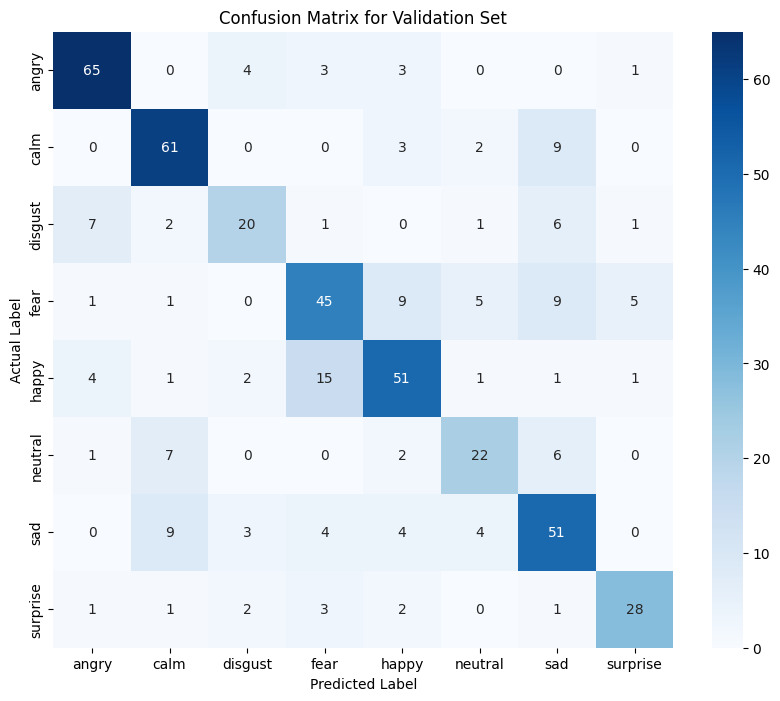

In [15]:
# --- 5. Evaluate the Final Model on the Validation Set ---
print("\n--- Generating Classification Report for Validation Set ---")

# Put the model in evaluation mode
model.eval()

# Store predictions and true labels
all_preds = []
all_labels = []

# No need to track gradients for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        
        # Get the predicted class (the one with the highest probability)
        _, predicted = torch.max(outputs.data, 1)
        
        # Append batch predictions and labels to the lists
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get the class names from the label encoder
class_names = le.classes_

# Print the classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


# --- (Optional but Recommended) Visualize the Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Validation Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()